In [3]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
X, y = shap.datasets.boston()

Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :func:`~sklearn.datasets.fetch_california_housing`) and the Ames housing
    datas

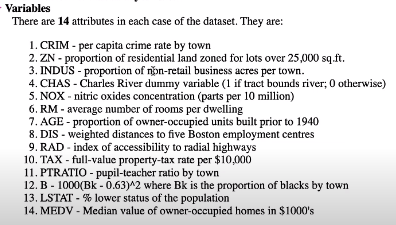

In [5]:
print(f"Mean value of median house prices (in $ thousand): {round(y.mean(), 2)}")

Mean value of median house prices (in $ thousand): 22.53


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

## Linear Regression

In [7]:
catagorical_features = ['CHAS']
numerical_features = [c for c in X_train.columns if c not in catagorical_features]
cat = [([c], [OrdinalEncoder()]) for c in catagorical_features]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num + cat, df_out=True)
preprocessed_X_train = mapper.fit_transform(X_train)
preprocessed_X_train = sm.add_constant(preprocessed_X_train)
reg = sm.OLS(y_train, preprocessed_X_train).fit()

In [8]:
def evaluate(X, y, mapper=None, reg=None, transform=False):
    if transform:
        X = mapper.transform(X)
        X = sm.add_constant(X, has_constant='add') 
    y_pred = reg.predict(X)
    return mean_absolute_error(y, y_pred)

In [9]:
train_mae = evaluate(X_train, y_train, mapper, reg, True)
test_mae = evaluate(X_test, y_test, mapper, reg, True)
print(f"train MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")

train MAE = 3.388, test MAE = 2.52 


In [10]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     97.41
Date:                Mon, 20 Feb 2023   Prob (F-statistic):          1.35e-120
Time:                        02:53:55   Log-Likelihood:                -1361.2
No. Observations:                 455   AIC:                             2750.
Df Residuals:                     441   BIC:                             2808.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.7675      0.240     95.013      0.000      22.297      23.238
CRIM          -0.9544      0.316     -3.021      0.003      -1.575      -0.333
ZN             1.1903      0.347      3.426      0.001       0.508       1.873
INDUS          0.2159      0.445      0.485      0.628      -0.659       1.091
NOX           -2.0944      0.505     -4.148      0.000      -3.087      -1.102
RM             2.7612      0.317      8.700      0.000       2.137       3.385
AGE            0.3042      0.411      0.739      0.460      -0.504       1.113
DIS           -3.1207      0.460     -6.788      0.000      -4.024      -2.217
RAD            2.9649      0.678      4.372      0.000       1.632       4.298
TAX           -2.4522      0.715     -3.430      0.001      -3.857      -1.047
PTRATIO       -2.0042      0.310     -6.468      0.000      -2.613      -1.395
B              0.8742      0.272      3.213      0.001       0.339       1.409
LSTAT         -4.0539      0.394    -10.283      0.000      -4.829      -3.279
CHAS           2.5088      0.895      2.804      0.005       0.750       4.267
==============================================================================
Omnibus:                      152.667   Durbin-Watson:                   1.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              592.005
Skew:                           1.474   Prob(JB):                    2.80e-129
Kurtosis:                       7.747   Cond. No.                         10.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Random Forest 

In [13]:
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
catagorical_features = ['CHAS']
numerical_features = [c for c in X_train.columns if c not in catagorical_features]
cat = [([c], [OrdinalEncoder()]) for c in catagorical_features]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num + cat, df_out=True)
reg = RandomForestRegressor()
pipeline = Pipeline([
    ('preprocess', mapper),
    ('reg', reg)
])
p = pipeline.fit(X_train, y_train)

train_mae = evaluate(X_train, y_train, reg=pipeline)
test_mae = evaluate(X_test, y_test, reg=pipeline)
print(f"train MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")

train MAE = 0.811, test MAE = 2.703 


<BarContainer object of 13 artists>

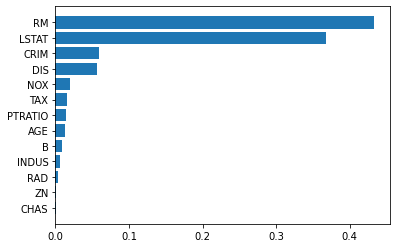

In [14]:
sorted_idx = reg.feature_importances_.argsort()
features = numerical_features + catagorical_features 
result = sorted(zip(features, reg.feature_importances_), key = lambda x: x[1], reverse=False)
plt.barh([x[0] for x in result], [x[1] for x in result])

## Neural Networks

In [15]:
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim

preprocessed_X_train = mapper.fit_transform(X_train)

num_epochs = 50
learning_rate = 0.01
hidden_size = 32
batch_size = 50
input_dim = preprocessed_X_train.shape[1]
batch_no = preprocessed_X_train.shape[0] // batch_size
model = nn.Sequential(
    nn.Linear(input_dim, hidden_size),
    nn.Linear(hidden_size, 1)
)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_batch = Variable(torch.FloatTensor(preprocessed_X_train.values[start:end]))
        y_batch = Variable(torch.FloatTensor(y_train[start:end]))
        optimizer.zero_grad()
        y_preds = model(x_batch)
        loss = criterion(y_preds, torch.unsqueeze(y_batch,dim=1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 0: 
        print("Epoch {}, Loss: {}".format(epoch, running_loss))
        
preprocessed_X_test = mapper.transform(X_test)
y_pred = model(torch.from_numpy(preprocessed_X_test.values).float()).flatten().detach().numpy()
test_mae = mean_absolute_error(y_test, y_pred)
preprocessed_X_train = mapper.transform(X_train)
y_pred = model(torch.from_numpy(preprocessed_X_train.values).float()).flatten().detach().numpy()
train_mae = mean_absolute_error(y_train, y_pred)
print(f"\ntrain MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")

Epoch 0, Loss: 5584.934143066406
Epoch 10, Loss: 361.8665728569031
Epoch 20, Loss: 222.9982614517212
Epoch 30, Loss: 216.44371128082275
Epoch 40, Loss: 214.44827461242676

train MAE = 3.396, test MAE = 2.487 


We don't have a direct way to identify feature importance for neural networks

## Problems with Interpretation
- No specific method to define feature importance that is model agnostic
- For a given sample, why does the prediction have that value?

Answer: Shap values

## Intuition of Model Interpretation

How we think about answering the question "Why is the output for this specific sample so low/high" manually?

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False) #revert
catagorical_features = ['CHAS']
numerical_features = [c for c in X_train.columns if c not in catagorical_features]
cat = [([c], [SimpleImputer(strategy='constant', fill_value=0),
              OrdinalEncoder()]) for c in catagorical_features]
num = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]
mapper = DataFrameMapper(num + cat, df_out=True)
reg = LinearRegression()
pipeline = Pipeline([
    ('preprocess', mapper),
    ('reg', reg)
])
p = pipeline.fit(X_train, y_train)

In [17]:
nan_frame = pd.DataFrame(columns=catagorical_features+numerical_features, index=[0])
nan_frame

,CHAS,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
base_value = round(pipeline.predict(nan_frame)[0], 3)
print(f"Expected value of the output (base value): {base_value}")

Expected value of the output (base value): 22.767


In [19]:
X_test.iloc[0: 1]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
455,4.75237,0.0,18.1,0.0,0.713,6.525,86.5,2.4358,24.0,666.0,20.2,50.92,18.13


In [20]:
sample_prediction = round(pipeline.predict(X_test.iloc[0: 1])[0], 3)
print(f"Current Prediction: {sample_prediction}, Actual value: {y_test[0]}")

Current Prediction: 15.851, Actual value: 14.1


**How did we get from 22.767 to 15.851?**
- Find this by adjusting individual feature values. But this can be hard to look at
- Fast way to visualize is with Partial Dependency Plots (which uses Shap values for individual samples)
- Shap values assign a contributing factor to every feature of every sample

## Partial Dependence Plots

In [21]:
explainer = shap.Explainer(pipeline.predict, X_train)
shap_values = explainer(X_test)

Permutation explainer: 52it [00:35,  1.44it/s]                                                                         


In [22]:
def partial_dependence_plot(feature, idx=None):
    if idx is None: # visualize all samples
        shap.plots.partial_dependence(
            feature,
            pipeline.predict,
            X_train, 
            ice=False,
            model_expected_value=True, 
            feature_expected_value=True)
    else: # visualize sample idx
        shap.partial_dependence_plot(
            feature, 
            pipeline.predict,
            X_train, 
            ice=False,
            model_expected_value=True, 
            feature_expected_value=True,
            shap_values=shap_values[idx:idx+1,:])

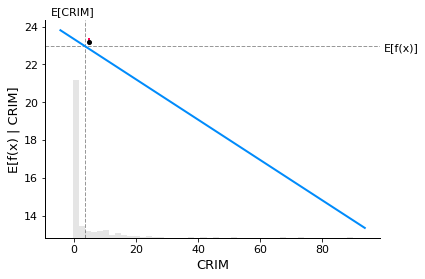

In [23]:
partial_dependence_plot('CRIM', 0)

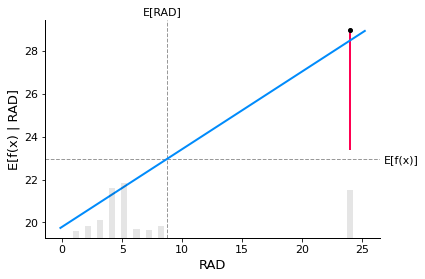

In [24]:
partial_dependence_plot('RAD', 0)

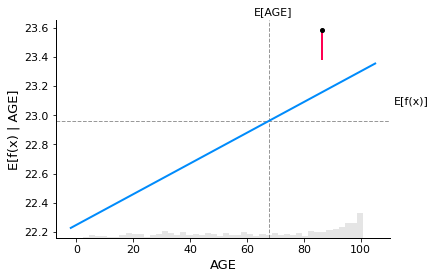

In [25]:
partial_dependence_plot('AGE', 0)

## Shap Plots

Hard to look at every feature for every sample. So lets look at all features of the same sample

In [26]:
shap.initjs()

In [27]:
def sample_feature_importance(idx, type='condensed'):
    if type == 'condensed':
        return shap.plots.force(shap_values[idx])
    elif type == 'waterfall':
        return shap.plots.waterfall(shap_values[idx])
    else:
        return "Return valid visual ('condensed', 'waterfall')"

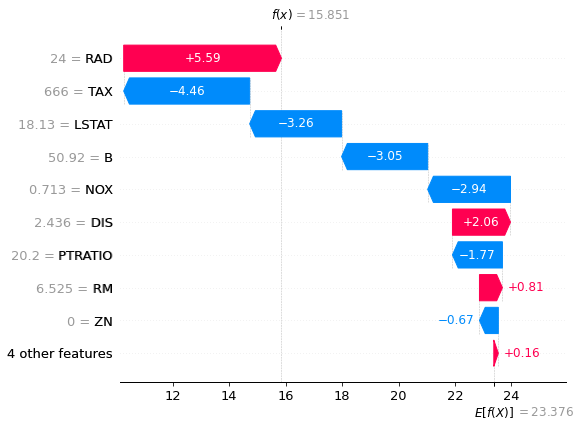

In [28]:
sample_feature_importance(0, 'waterfall')

In [29]:
sample_feature_importance(0, 'condensed')

## Feature Importance for model

Looking at individual samples can be a bother. Let's look at all samples together

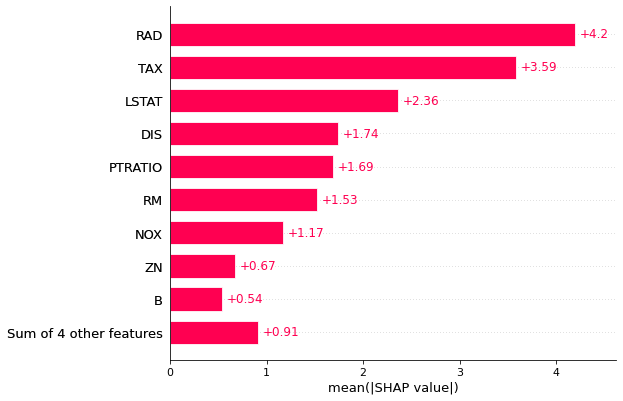

In [30]:
shap.plots.bar(shap_values)

Two most important features according to the LinearRegression model:
- RAD: index of accessibility to radial highways
- TAX: full-value property-tax rate per $10,000

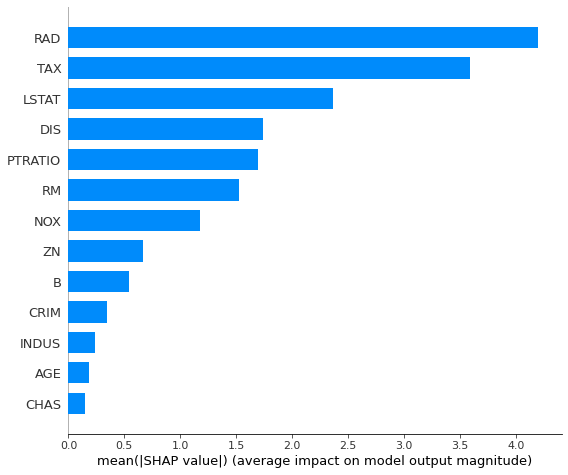

In [31]:
shap.summary_plot(shap_values.values, X_train, plot_type='bar')

We can interpret the neural network model in the same way

In [32]:
preprocessed_X_train = mapper.fit_transform(X_train)

num_epochs = 50
learning_rate = 0.01
hidden_size = 32
batch_size = 50
input_dim = preprocessed_X_train.shape[1]
batch_no = preprocessed_X_train.shape[0] // batch_size
model = nn.Sequential(
    nn.Linear(input_dim, hidden_size),
    nn.Linear(hidden_size, 1)
)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_batch = Variable(torch.FloatTensor(preprocessed_X_train.values[start:end]))
        y_batch = Variable(torch.FloatTensor(y_train[start:end]))
        optimizer.zero_grad()
        y_preds = model(x_batch)
        loss = criterion(y_preds, torch.unsqueeze(y_batch,dim=1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 0: 
        print("Epoch {}, Loss: {}".format(epoch, running_loss))
        
preprocessed_X_test = mapper.transform(X_test)
y_pred = model(torch.from_numpy(preprocessed_X_test.values).float()).flatten().detach().numpy()
test_mae = mean_absolute_error(y_test, y_pred)
preprocessed_X_train = mapper.transform(X_train)
y_pred = model(torch.from_numpy(preprocessed_X_train.values).float()).flatten().detach().numpy()
train_mae = mean_absolute_error(y_train, y_pred)
print(f"\ntrain MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")

Epoch 0, Loss: 5588.462707519531
Epoch 10, Loss: 358.6965317726135
Epoch 20, Loss: 218.06363677978516
Epoch 30, Loss: 213.95636463165283
Epoch 40, Loss: 213.13847255706787

train MAE = 3.394, test MAE = 2.504 


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


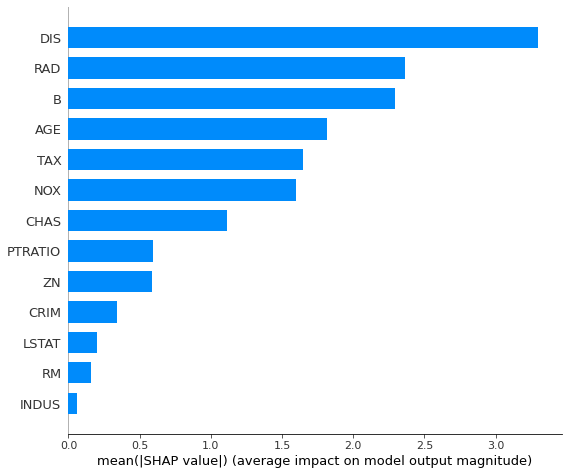

In [33]:
explainer = shap.DeepExplainer(model, torch.from_numpy(preprocessed_X_train.values).float())
shap_values = explainer.shap_values(torch.from_numpy(preprocessed_X_test.values).float())
shap.summary_plot(shap_values, X_test, plot_type='bar')

Most important features for this neural network:
- DIS: weighted distances to five Boston employment centres
- RAD: index of accessibility to radial highways